In [187]:
import sys
sys.path.append("/Users/ueki/.pyenv/versions/3.7.3/lib/python3.7/site-packages")

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

## create data

In [189]:
# prepare dataset
np.random.seed(777)
N = 200 # num of data
D = 4 # dim

In [190]:
omega = np.random.randn(D)
noise = 0.8 * np.random.randn(N)
lam = 0.01
x = np.random.randn(N,D)
y = 2 *(np.sum(omega*x,axis=1)+noise>0)-1

In [191]:
N_iter = 300

# batch steepest gradient method

In [192]:
#epoch
num_iter = N_iter
#重みの初期値
ww = np.ones(D)
#learning rate-> Lipsittsのuppper boundをlrにする
alpha_base = 0.01
#learning history
grad_loss_history = []
grad_ww_history = []
# lr descent しなくていいから、いらないかも
lip = 0.25*np.max(x**2)
#ここよくわかってない
#alpha_base = 1/lip

In [193]:
alpha_base

0.01

In [194]:
for t in range(1,num_iter+1):
    posterior = 1/(1+np.exp(-y*(np.dot(x,ww)))) # \in (N,))
    grad = 1/N*np.sum(np.dot((1-posterior),x*y.reshape(-1,1))) + 2*lam*ww # \in D
    loss = 1/N*np.sum(np.log(1+np.exp(-y*np.dot(x,ww))))+lam*(np.dot(ww.T,ww))
    grad_ww_history.append(ww)
    grad_loss_history.append(loss)
    #update
    ww = ww+alpha_base*grad

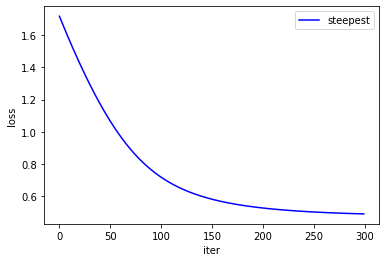

In [195]:
plt.plot(grad_loss_history, 'b', markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

# newton based method

In [196]:
#epoch
num_iter = N_iter
#重みの初期値
ww = np.ones(D)
#learning history
newton_loss_history = []
newton_ww_history = []

In [201]:

for t in range(1,num_iter+1):
    posterior = 1/(1+np.exp(-y*(np.dot(x,ww)))) # \in (N,))
    grad = 1/N*np.sum(np.dot((1-posterior),x*y.reshape(-1,1))) + 2*lam*ww # \in D
    hess = 1/N*np.sum(np.dot(posterior.T,posterior)*np.dot(x.T,x))+2*lam 
    loss = 1/N*np.sum(np.log(np.exp(-y*np.dot(x,ww))))+lam*(np.dot(ww.T,ww))
    newton_ww_history.append(ww)
    newton_loss_history.append(loss)
    
    #update
    ww = ww + grad/hess

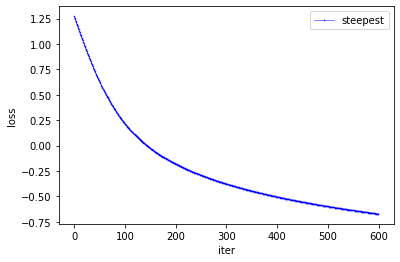

In [202]:
plt.plot( newton_loss_history, 'bo-', linewidth=0.5, markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

# compare performance

In [203]:
optimal_w = min(min(grad_loss_history),min(newton_loss_history))

Text(0, 0.5, 'Loss diff from the gold weight')

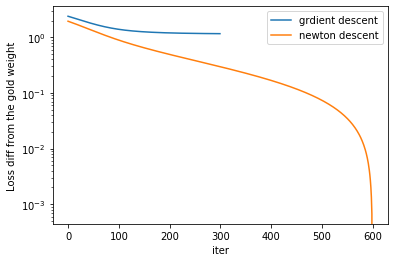

In [204]:
plt.plot(np.abs(grad_loss_history-optimal_w),label="grdient descent")
plt.plot(np.abs(newton_loss_history-optimal_w),label="newton descent")
plt.legend()
plt.yscale("log")
plt.xlabel("iter")
plt.ylabel("Loss diff from the gold weight")